# Real-World Data Demonstration

### Team Epsilon-Greedy Quants
#### Michael Lee, Nikat Patel, Jose Antonio Alatorre Sanchez

This notebook demonstrates what a user sees when the user runs the User Guide for Real-World Data Notebook

In [1]:
from environments.e_greedy import DeepTradingEnvironment, LinearAgent

import datetime
import numpy as np
import pandas as pd
import os
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier
from pypfopt.cla import CLA
import matplotlib.pyplot as plt
from matplotlib import cm
import copy
import quantstats as qs
qs.extend_pandas()

In [2]:
root = os.getcwd()
data_env = root+"/data_env/"

# Utility Functions

In [3]:
def _retrieve_asset_dict():
    # obtain close prices from parquet files of ETF price history
    root = os.getcwd()
    data_env = root+"/data_env_MTUM-USMV/"
    files = [_ for _ in os.listdir(data_env) if "parquet" in _]
    assets_dict = {file: pd.read_parquet(data_env + "/" + file) for file in files}
    counter=0
    for key, value in assets_dict.items():
        if counter==0:
            main_index=value.index
    else:
        main_index=main_index.join(value.index,how="inner")
        
    for key, value in assets_dict.items():
        tmp_df=value.reindex(main_index)
        tmp_df=tmp_df.fillna(method='ffill')
        assets_dict[key]=tmp_df['close']
    return assets_dict

def build_portfolio_df(asset_dict):
    portfolio_df = pd.DataFrame()
    
    for key, value in assets_dict.items():
        key = key.split(".")[0]
        tmp_df = pd.DataFrame(data=value)
        tmp_df.columns=[key]
        portfolio_df = pd.concat([portfolio_df, tmp_df], axis=1)
        
    portfolio_df.index = pd.to_datetime(portfolio_df.index, errors='coerce')
    return portfolio_df

In [4]:
def plot_backtest(linear_agent_train, env_test, test_input, model_run, model):
    ## Create plot of backtest returns
    if not "backtest" in locals():
        backtest=None
    backtest, tmp_weights =linear_agent_train.backtest_policy(epoch=1,backtest=backtest, env_test=env_test, test_input=test_input)
    plt.figure(figsize=(8,4))
    plt.plot(backtest,color="blue")
    plt.gcf().autofmt_xdate()
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel("Date", fontsize = 10)
    plt.ylabel("Backtest", fontsize = 10)
    plt.title("Backtest on Test Data: "+ model,fontsize = 16)
    plt.savefig(root+'/temp_persisted_data/test_backtest_plot_'+model_run+model+'.png')
    tmp_weights.to_csv(root+'/temp_persisted_data/test_backtest_weights_'+model_run+model+'.csv')
    plt.show()
    return backtest

# Reviewing Real-World Data

In [5]:
# read a sample ETF

data_env_two_asset = root+ "/data_env_MTUM-USMV/"

pd.read_parquet(data_env_two_asset+'MTUM.parquet').head()



,open,high,low,close,volume
index,,,,,
2017-01-03 05:00:00+00:00,72.59413,72.90881,72.21272,72.54646,297832
2017-01-04 05:00:00+00:00,72.69902,73.09952,72.69902,72.97556,225891
2017-01-05 05:00:00+00:00,72.98509,73.25208,72.84206,73.21394,412561
2017-01-06 05:00:00+00:00,73.20441,73.77654,73.04230,73.63351,260918
2017-01-09 05:00:00+00:00,73.66212,73.76701,73.50001,73.60490,165800


In [6]:
# create a portfolio
assets_dict = _retrieve_asset_dict()
portfolio_df = build_portfolio_df(assets_dict)

In [7]:
# create a train dataset and de-mean the time series

portfolio_df_train = portfolio_df[portfolio_df.index <= '2020-04-01']
portfolio_df_train = portfolio_df_train[portfolio_df_train.index >= '2018-01-24']
portfolio_df_train.sub(portfolio_df_train.mean())

portfolio_df_train.head()

,MTUM,USMV
index,,
2018-01-24 05:00:00+00:00,107.7541,51.58798
2018-01-25 05:00:00+00:00,107.9952,51.84317
2018-01-26 05:00:00+00:00,109.5190,52.27796
2018-01-29 05:00:00+00:00,108.6896,51.88098
2018-01-30 05:00:00+00:00,107.0211,51.57853


In [8]:
# create a test dataset consisting of 6 months of data and de-mean the time series

portfolio_df_test = portfolio_df[portfolio_df.index >= '2020-04-16']
portfolio_df_test = portfolio_df_test[portfolio_df_test.index <= '2020-11-16']
portfolio_df_test.sub(portfolio_df_test.mean())

portfolio_df_test.head()

,MTUM,USMV
index,,
2020-04-16 04:00:00+00:00,116.0638,57.85078
2020-04-17 04:00:00+00:00,117.9653,59.53394
2020-04-20 04:00:00+00:00,116.7009,58.23692
2020-04-21 04:00:00+00:00,112.3304,56.78149
2020-04-22 04:00:00+00:00,115.3270,57.81118


In [9]:
test_input_returns = portfolio_df_test.to_returns().dropna()
test_input_returns = test_input_returns.loc[(test_input_returns != 0).any(1)]


# Set Up Environment

In [10]:
# parameters related to the transformation of data, this parameters govern an step before the algorithm
out_reward_window=datetime.timedelta(days=7)

meta_parameters = {"in_bars_count": 14,
                   "out_reward_window":out_reward_window ,
                   "state_type":"in_window_out_window",
                   "risk_aversion":0,
                   "include_previous_weights":False}

# parameters that are related to the objective/reward function construction
objective_parameters = {"percent_commission": .001}

print("===Meta Parameters===")
print(meta_parameters)
print("===Objective Parameters===")
print(objective_parameters)

detrend=False

# create an environment and build features based on Real-World Dataset located in the "data_env" folder 
env = DeepTradingEnvironment.build_environment_from_dirs_and_transform(meta_parameters, objective_parameters,data_hash="MTUM-USMV", data_dir="data_env_MTUM-USMV", detrend=detrend)

number_of_assets = env.number_of_assets

===Meta Parameters===
{'in_bars_count': 14, 'out_reward_window': datetime.timedelta(days=7), 'state_type': 'in_window_out_window', 'risk_aversion': 0, 'include_previous_weights': False}
===Objective Parameters===
{'percent_commission': 0.001}


#### Split Features and Forward Returns into Training and Test sets

In [11]:
features = pd.read_parquet("temp_persisted_data/only_features_MTUM-USMV")
features

,MTUM.parquet_log_returns,USMV.parquet_log_returns,MTUM.parquet_log_returns_lag_0,USMV.parquet_log_returns_lag_0,MTUM.parquet_log_returns_lag_1,USMV.parquet_log_returns_lag_1,MTUM.parquet_log_returns_lag_2,USMV.parquet_log_returns_lag_2,MTUM.parquet_log_returns_lag_3,USMV.parquet_log_returns_lag_3,...,USMV.parquet_log_returns_lag_9,MTUM.parquet_log_returns_lag_10,USMV.parquet_log_returns_lag_10,MTUM.parquet_log_returns_lag_11,USMV.parquet_log_returns_lag_11,MTUM.parquet_log_returns_lag_12,USMV.parquet_log_returns_lag_12,MTUM.parquet_log_returns_lag_13,USMV.parquet_log_returns_lag_13,bias
index,,,,,,,,,,,,,,,,,,,,,
2018-01-24 05:00:00+00:00,-0.002235,0.000550,0.001251,0.001651,0.006099,0.006263,0.005865,0.004259,-0.001085,-0.001854,...,0.000561,0.002807,0.001686,0.007997,0.005074,0.008348,0.003964,0.009956,0.002083,1
2018-01-25 05:00:00+00:00,0.002235,0.004935,-0.002235,0.000550,0.001251,0.001651,0.006099,0.006263,0.005865,0.004259,...,-0.004874,0.003731,0.000561,0.002807,0.001686,0.007997,0.005074,0.008348,0.003964,1
2018-01-26 05:00:00+00:00,0.014011,0.008352,0.002235,0.004935,-0.002235,0.000550,0.001251,0.001651,0.006099,0.006263,...,0.003002,-0.001025,-0.004874,0.003731,0.000561,0.002807,0.001686,0.007997,0.005074,1
2018-01-29 05:00:00+00:00,-0.007602,-0.007623,0.014011,0.008352,0.002235,0.004935,-0.002235,0.000550,0.001251,0.001651,...,0.002993,0.006780,0.003002,-0.001025,-0.004874,0.003731,0.000561,0.002807,0.001686,1
2018-01-30 05:00:00+00:00,-0.015470,-0.005847,-0.007602,-0.007623,0.014011,0.008352,0.002235,0.004935,-0.002235,0.000550,...,-0.000748,0.009490,0.002993,0.006780,0.003002,-0.001025,-0.004874,0.003731,0.000561,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-10 05:00:00+00:00,-0.012501,0.007082,-0.029419,0.016159,-0.000195,0.003387,0.018257,0.008517,0.043942,0.010946,...,-0.007520,-0.011240,-0.014872,0.002614,0.003080,-0.000939,0.003399,-0.005482,0.001394,1
2020-11-11 05:00:00+00:00,0.020153,0.004793,-0.012501,0.007082,-0.029419,0.016159,-0.000195,0.003387,0.018257,0.008517,...,-0.030010,0.001556,-0.007520,-0.011240,-0.014872,0.002614,0.003080,-0.000939,0.003399,1
2020-11-12 05:00:00+00:00,-0.002721,-0.010364,0.020153,0.004793,-0.012501,0.007082,-0.029419,0.016159,-0.000195,0.003387,...,0.002589,-0.034095,-0.030010,0.001556,-0.007520,-0.011240,-0.014872,0.002614,0.003080,1


In [12]:
features = pd.read_parquet("temp_persisted_data/only_features_MTUM-USMV")

features_train = features[features.index <= '2020-04-01']
features_train.sub(features_train.mean()) 

features_test = features[features.index >= '2020-04-16']
features_test = features_test[features_test.index <= '2020-11-16']
features_test.sub(features_test.mean())

features_train.head()

,MTUM.parquet_log_returns,USMV.parquet_log_returns,MTUM.parquet_log_returns_lag_0,USMV.parquet_log_returns_lag_0,MTUM.parquet_log_returns_lag_1,USMV.parquet_log_returns_lag_1,MTUM.parquet_log_returns_lag_2,USMV.parquet_log_returns_lag_2,MTUM.parquet_log_returns_lag_3,USMV.parquet_log_returns_lag_3,...,USMV.parquet_log_returns_lag_9,MTUM.parquet_log_returns_lag_10,USMV.parquet_log_returns_lag_10,MTUM.parquet_log_returns_lag_11,USMV.parquet_log_returns_lag_11,MTUM.parquet_log_returns_lag_12,USMV.parquet_log_returns_lag_12,MTUM.parquet_log_returns_lag_13,USMV.parquet_log_returns_lag_13,bias
index,,,,,,,,,,,,,,,,,,,,,
2018-01-24 05:00:00+00:00,-0.002235,0.000550,0.001251,0.001651,0.006099,0.006263,0.005865,0.004259,-0.001085,-0.001854,...,0.000561,0.002807,0.001686,0.007997,0.005074,0.008348,0.003964,0.009956,0.002083,1
2018-01-25 05:00:00+00:00,0.002235,0.004935,-0.002235,0.000550,0.001251,0.001651,0.006099,0.006263,0.005865,0.004259,...,-0.004874,0.003731,0.000561,0.002807,0.001686,0.007997,0.005074,0.008348,0.003964,1
2018-01-26 05:00:00+00:00,0.014011,0.008352,0.002235,0.004935,-0.002235,0.000550,0.001251,0.001651,0.006099,0.006263,...,0.003002,-0.001025,-0.004874,0.003731,0.000561,0.002807,0.001686,0.007997,0.005074,1
2018-01-29 05:00:00+00:00,-0.007602,-0.007623,0.014011,0.008352,0.002235,0.004935,-0.002235,0.000550,0.001251,0.001651,...,0.002993,0.006780,0.003002,-0.001025,-0.004874,0.003731,0.000561,0.002807,0.001686,1
2018-01-30 05:00:00+00:00,-0.015470,-0.005847,-0.007602,-0.007623,0.014011,0.008352,0.002235,0.004935,-0.002235,0.000550,...,-0.000748,0.009490,0.002993,0.006780,0.003002,-0.001025,-0.004874,0.003731,0.000561,1


In [13]:
forward_return_dates = pd.read_parquet("temp_persisted_data/forward_return_dates_MTUM-USMV")

forward_return_dates_train = forward_return_dates[forward_return_dates.index <= '2020-04-01']

forward_return_dates_test = forward_return_dates[forward_return_dates.index > '2020-04-16']
forward_return_dates_test = forward_return_dates_test[forward_return_dates_test.index <= '2020-11-16']

forward_return_dates_train.head()

,"forward_return_7_days,_0:00:00"
index,
2018-01-24 05:00:00+00:00,2018-01-31 05:00:00+00:00
2018-01-25 05:00:00+00:00,2018-02-01 05:00:00+00:00
2018-01-26 05:00:00+00:00,2018-02-02 05:00:00+00:00
2018-01-29 05:00:00+00:00,2018-02-05 05:00:00+00:00
2018-01-30 05:00:00+00:00,2018-02-06 05:00:00+00:00


In [14]:
forward_returns = pd.read_parquet("temp_persisted_data/only_forward_returns_MTUM-USMV")

forward_returns_train = forward_returns[forward_returns.index <= '2020-04-01']
forward_returns_train.sub(forward_returns_train.mean()) 

forward_returns_test = forward_returns[forward_returns.index >= '2020-04-16']
forward_returns_test = forward_returns_test[forward_returns_test.index <= '2020-11-16']
forward_returns_test.sub(forward_returns_test.mean()) 

forward_returns_train.head()

,"MTUM.parquet_forward_return_7_days,_0:00:00","USMV.parquet_forward_return_7_days,_0:00:00"
index,,
2018-01-24 05:00:00+00:00,-0.001074,0.000733
2018-01-25 05:00:00+00:00,-0.004286,-0.006928
2018-01-26 05:00:00+00:00,-0.040772,-0.031640
2018-01-29 05:00:00+00:00,-0.074801,-0.059392
2018-01-30 05:00:00+00:00,-0.037578,-0.047829


# Run Policy-Gradient Method Algorithms on Real-World Data

In [15]:
max_iter = 4001
model_run = "MTUM-USMV_reward_variance_risk_0_"
sample_observations = 32
plot_interval = 500

### REINFORCE

 12%|█████████▊                                                                     | 500/4001 [02:36<14:16,  4.09it/s]

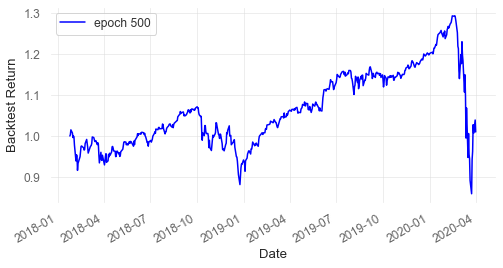

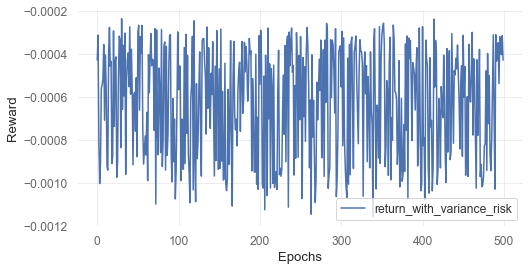

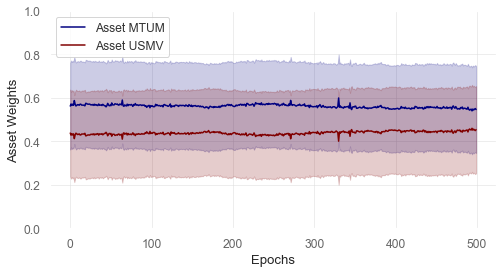

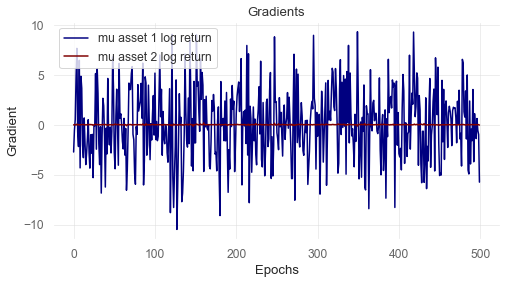

 25%|███████████████████▍                                                          | 1000/4001 [05:11<17:19,  2.89it/s]

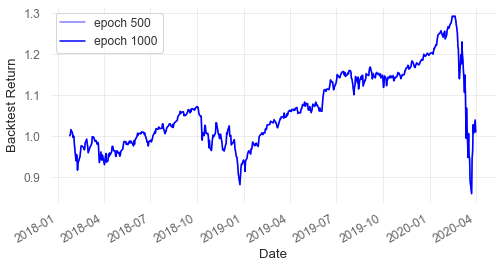

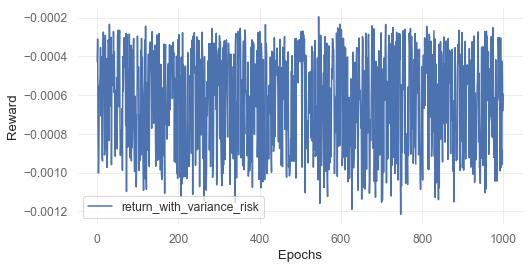

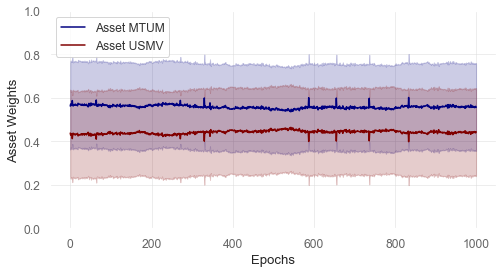

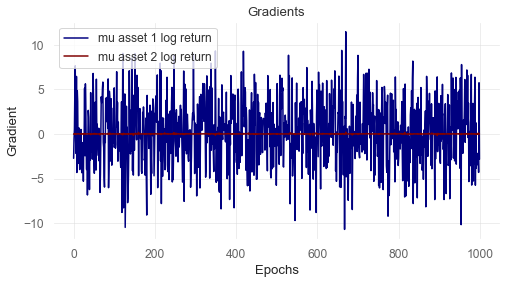

 37%|█████████████████████████████▏                                                | 1500/4001 [07:25<10:46,  3.87it/s]

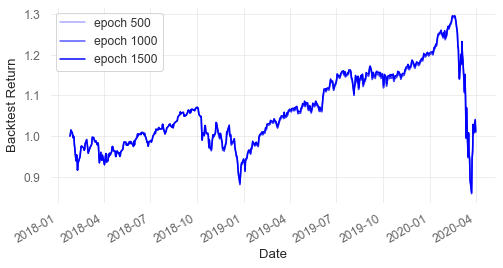

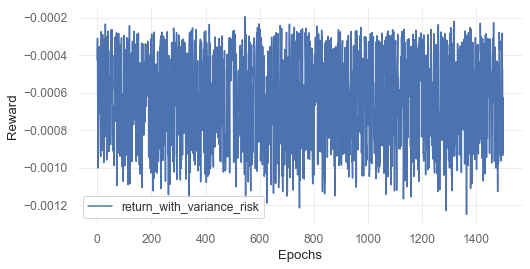

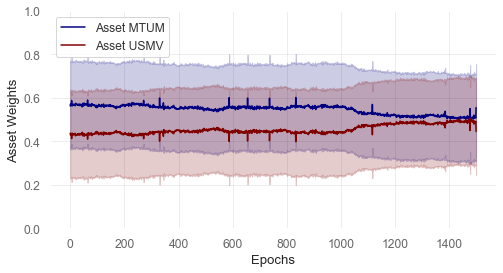

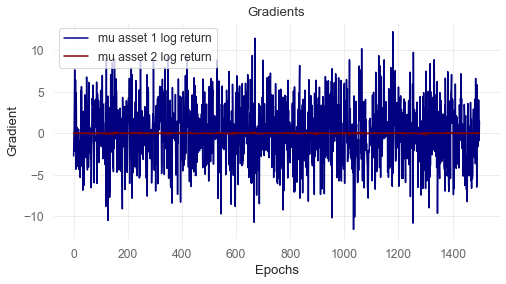

 50%|██████████████████████████████████████▉                                       | 2000/4001 [10:00<11:19,  2.94it/s]

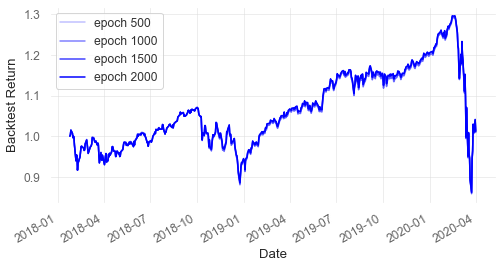

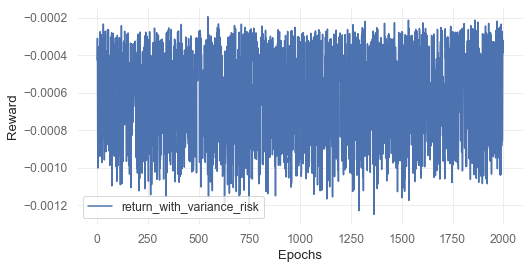

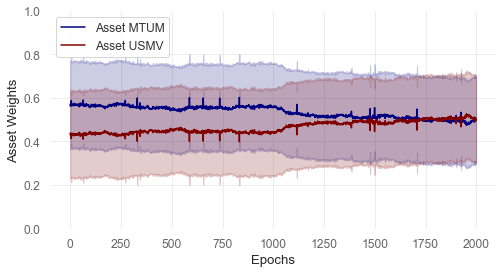

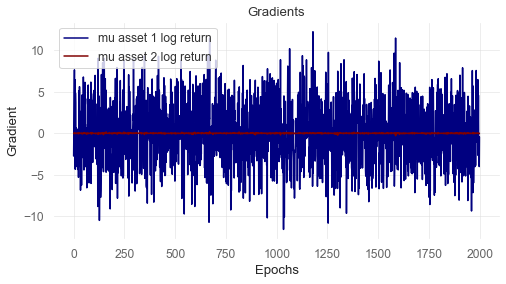

 62%|████████████████████████████████████████████████▋                             | 2500/4001 [12:49<09:24,  2.66it/s]

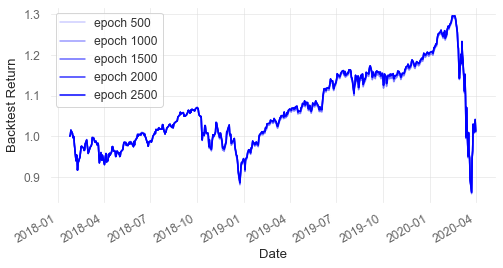

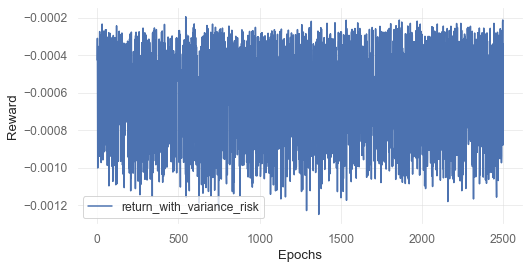

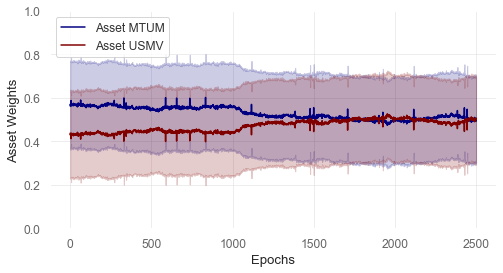

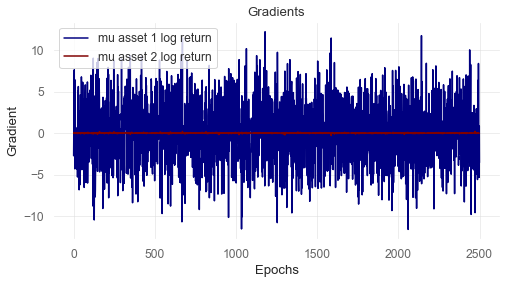

 75%|██████████████████████████████████████████████████████████▍                   | 3000/4001 [15:30<05:39,  2.95it/s]

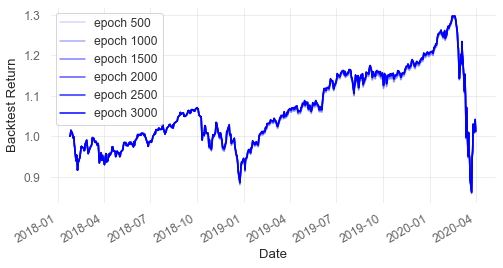

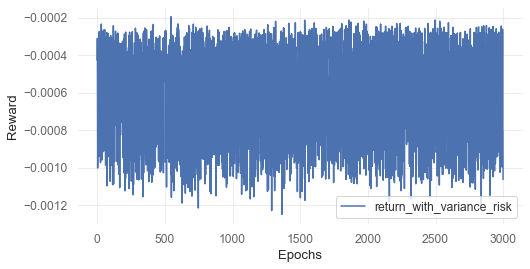

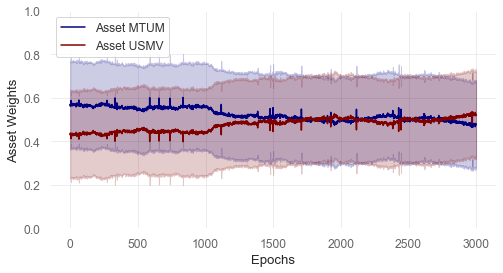

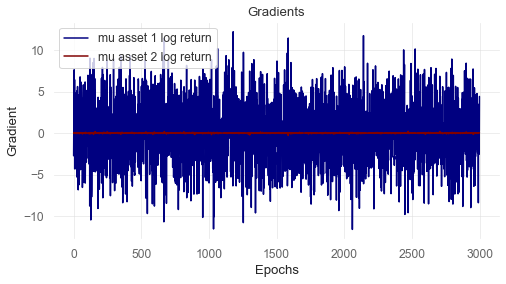

 87%|████████████████████████████████████████████████████████████████████▏         | 3500/4001 [18:29<03:36,  2.32it/s]

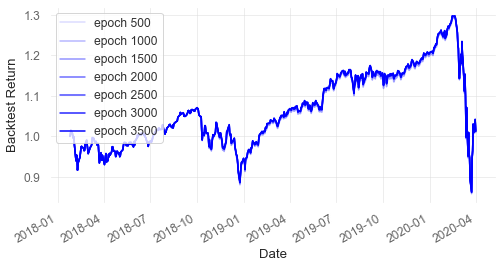

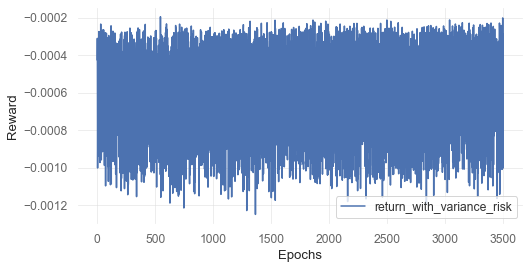

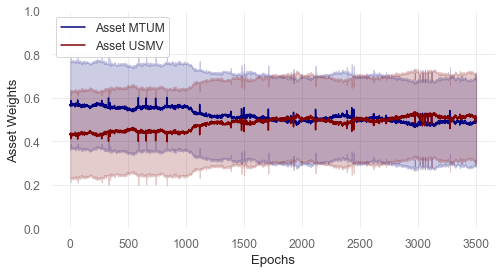

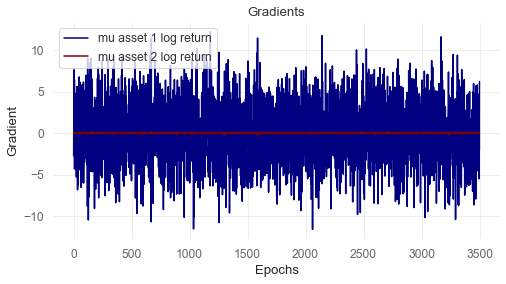

100%|█████████████████████████████████████████████████████████████████████████████▉| 4000/4001 [21:23<00:00,  3.54it/s]

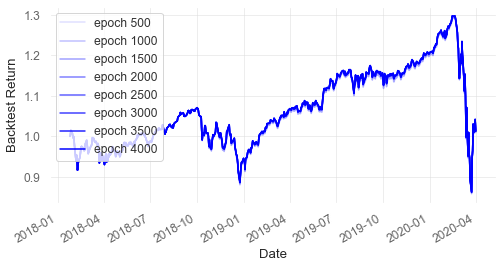

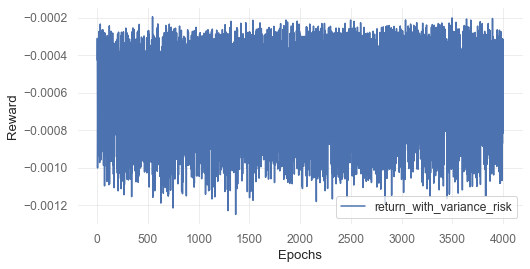

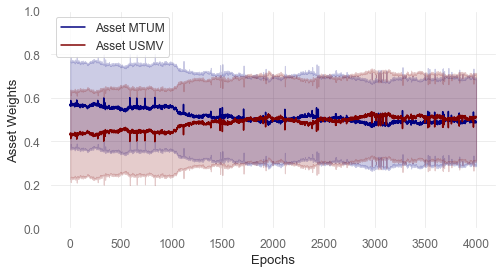

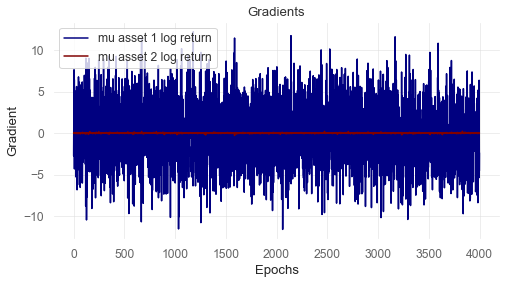

100%|██████████████████████████████████████████████████████████████████████████████| 4001/4001 [21:27<00:00,  1.43s/it]

[]

In [16]:
# create environment and run REINFORCE

env_reinforce_train=DeepTradingEnvironment(features_train, forward_returns_train, forward_return_dates_train, objective_parameters,
                 meta_parameters)
env_reinforce_test = DeepTradingEnvironment(features_test, forward_returns_test, forward_return_dates_test, objective_parameters,
                 meta_parameters)

linear_agent_reinforce = LinearAgent(environment=env_reinforce_train,out_reward_window_td=out_reward_window, reward_function="return_with_variance_risk",sample_observations=sample_observations)
linear_agent_reinforce.REINFORCE_fit(max_iterations=max_iter, add_baseline=False, plot_every = plot_interval, train_input = portfolio_df_train, model_run = model_run, detrend=detrend, verbose=True)

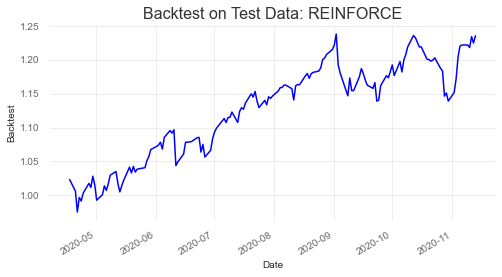

In [17]:
# perform backtest 
backtest_reinforce = plot_backtest(linear_agent_reinforce, env_reinforce_test, portfolio_df_test, model_run, model="REINFORCE")
backtest_reinforce.to_csv('temp_persisted_data/'+model_run+'backtest_reinforce.csv')

<AxesSubplot:xlabel='index'>

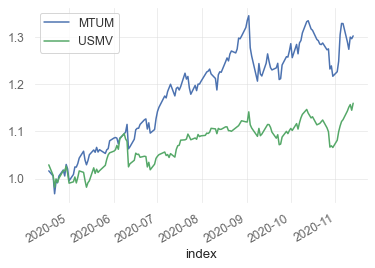

In [18]:
(test_input_returns+1).cumprod().plot()

<AxesSubplot:xlabel='index'>

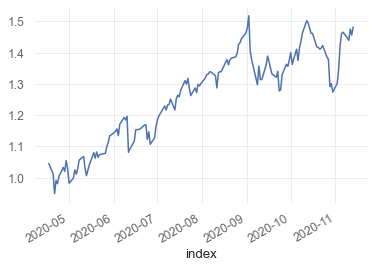

In [19]:
(test_input_returns.sum(axis=1)+1).cumprod().plot()

### REINFORCE with Baseline


pre-sampling indices:  65%|█████████████████████████████████████▋                    | 256/394 [00:07<00:03, 34.76it/s]


pre-sampling indices: 100%|██████████████████████████████████████████████████████████| 394/394 [00:11<00:00, 34.00it/s]

  1%|▌                                                                               | 31/4001 [00:11<25:00,  2.65it/s]


  2%|█▉                                                                              | 97/4001 [00:33<22:03,  2.95it/s]


  4%|███▏                                                                           | 163/4001 [00:56<23:14,  2.75it/s]


  6%|████▌                                                                          | 229/4001 [01:20<19:50,  3.17it/s]


  7%|█████▊                                                                         | 295/4001 [01:43<20:47,  2.97it/s]


  9%|███████▏                                                                       | 361/4001 [02:11<22:16,  2.72it/s]


 11%|████████▍                                                                      | 427/4001 [02:36<29:00,  2.05it/s]


 12%|█████████▋                                                                     | 493/4001 [03:03<20:58,  2.79it/s]


 12%|█████████▊                                                                     | 500/4001 [03:05<19:28,  3.00it/s]

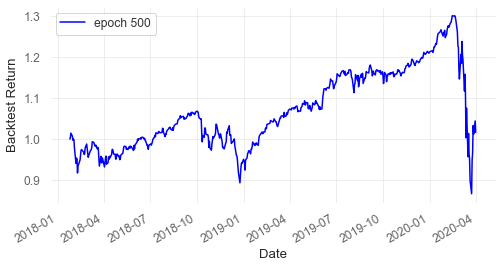

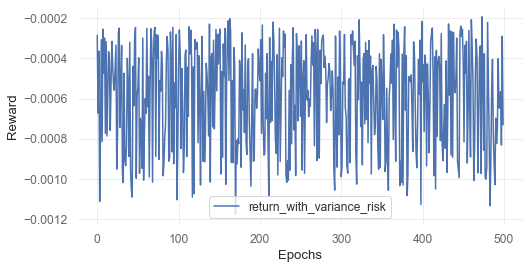

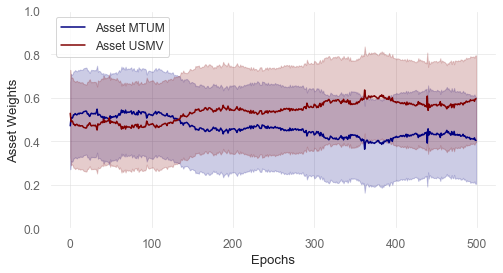

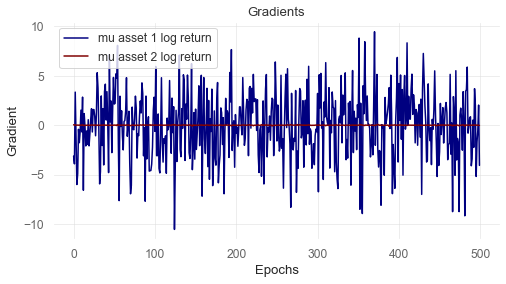


 14%|███████████▏                                                                   | 566/4001 [03:35<24:32,  2.33it/s]


 16%|████████████▍                                                                  | 632/4001 [03:59<18:01,  3.12it/s]


 17%|█████████████▊                                                                 | 698/4001 [04:23<17:50,  3.08it/s]


 19%|███████████████                                                                | 764/4001 [04:50<19:47,  2.73it/s]


 19%|███████████████▎                                                               | 777/4001 [04:55<21:04,  2.55it/s]

In [ ]:
# create environment and run REINFORCE with baseline
env_reinforce_baseline_train = DeepTradingEnvironment(features_train, forward_returns_train, forward_return_dates_train, objective_parameters,
                 meta_parameters)
env_reinforce_baseline_test = DeepTradingEnvironment(features_test, forward_returns_test, forward_return_dates_test, objective_parameters,
                 meta_parameters)

linear_agent_reinforce_baseline = LinearAgent(environment=env_reinforce_baseline_train,out_reward_window_td=out_reward_window, reward_function="return_with_variance_risk",sample_observations=sample_observations)
linear_agent_reinforce_baseline.REINFORCE_fit(max_iterations=max_iter, add_baseline=True, plot_every = plot_interval, train_input = portfolio_df_train, model_run = model_run, detrend=detrend, verbose=True)

In [ ]:
# perform backtest 
backtest_reinforce_baseline = plot_backtest(linear_agent_reinforce_baseline, env_reinforce_baseline_test, portfolio_df_test, model_run, model="REINFORCE with Baseline")
backtest_reinforce_baseline.to_csv('temp_persisted_data/'+model_run+'backtest_reinforce_baseline.csv')

### Actor-Critic

In [ ]:
# create environment and run Actor-Critic 

env_actor_critic_no_trace_train = DeepTradingEnvironment(features_train, forward_returns_train, forward_return_dates_train, objective_parameters,
                 meta_parameters)
env_actor_critic_no_trace_test = DeepTradingEnvironment(features_test, forward_returns_test, forward_return_dates_test, objective_parameters,
                 meta_parameters)

linear_agent_actor_critic_no_trace = LinearAgent(environment=env_actor_critic_no_trace_train,out_reward_window_td=out_reward_window, reward_function="return_with_variance_risk",sample_observations=sample_observations)
linear_agent_actor_critic_no_trace.ACTOR_CRITIC_FIT(use_traces=False,max_iterations=max_iter, plot_every = plot_interval,train_input = portfolio_df_train, model_run = model_run, detrend=detrend, verbose=True)

In [ ]:
# perform backtest
backtest_actor_critic_no_trace = plot_backtest(linear_agent_actor_critic_no_trace, env_actor_critic_no_trace_test,  portfolio_df_test, model_run, model="Actor-Critic without Eligibility Traces")
backtest_actor_critic_no_trace.to_csv('temp_persisted_data/'+model_run+'backtest_actor_critic_no_trace.csv')

### Actor-Critic with Eligibility Traces

In [ ]:
# create environment and run Actor-Critic with Eligibility Traces 
env_actor_critic_trace_train = DeepTradingEnvironment(features_train, forward_returns_train, forward_return_dates_train, objective_parameters,
                 meta_parameters)
env_actor_critic_trace_test = DeepTradingEnvironment(features_test, forward_returns_test, forward_return_dates_test, objective_parameters,
                 meta_parameters)

linear_agent_actor_critic_trace = LinearAgent(environment=env_actor_critic_trace_train,out_reward_window_td=out_reward_window, reward_function="return_with_variance_risk",sample_observations=sample_observations)
linear_agent_actor_critic_trace.ACTOR_CRITIC_FIT(use_traces=True,max_iterations=max_iter, plot_every = plot_interval,train_input = portfolio_df_train, model_run = model_run, detrend=detrend, verbose=True)

In [ ]:
# perform backtest 
backtest_actor_critic_trace = plot_backtest(linear_agent_actor_critic_trace, env_actor_critic_trace_test,  portfolio_df_test, model_run, model="Actor-Critic with Eligibility Traces")
backtest_actor_critic_trace.to_csv('temp_persisted_data/'+model_run+'backtest_actor_critic_trace.csv')